# Versuch den modifizierten Watershed-Segmentierungsansatz nach Laskhaman

Zunächst müssen wir ein paar Pakete laden.

In [1]:
%load_ext Cython

import numpy as np

import scipy.ndimage.filters as filters
import scipy.ndimage as ndi
from skimage import morphology as skmor
import datetime as dt

import l15_msevi.msevi as msv
from analysis_tools import segmentation as sgm

import cython

import matplotlib.pyplot as plt
%matplotlib inline

Zunächst definieren wir die nötigen Funktionen. 

Nun die Funktionen für den erweiterten Watershed-Algorithmus.

Zuerst die Funktion, um eine Matrix zu quantisieren.

In [2]:
def quantise_field(field,lower_limit,upper_limit,delta):
    """
    Quantises a given array into discrete steps within given limits and step width.
    
    Parameters
    ----------
    field: numpy array, 2d
        array to quantise
    limit1: float
        first limit for the quantisation
    limit2: float
        second limit for the quantisation
    delta: float
        width of the quantisation steps, if delta > 0 the quantisation will be based on the field maxima and if it
        it < 0 on the field minima
    """
    
    quant = np.zeros_like(field)
    
    too_small = np.where(field <= lower_limit)
    too_large = np.where(field > upper_limit)
    right = np.where(np.logical_and(field > lower_limit,field <= upper_limit) )
    
    if delta < 0:
        quant[too_small] = np.rint((lower_limit-upper_limit)/delta)
        quant[too_large] = 0
        quant[right] = np.rint((field[right] - upper_limit) / delta)
        
        return quant
    elif delta > 0:
        quant[too_large] = np.rint((upper_limit-lower_limit)/delta)
        quant[too_small] = 0
        quant[right] = np.rint((field[right] - lower_limit) / delta)
        
        return quant
    else:
        print("Impossible combination. If limit1 > limit2, delta has to be < 0 and if limit1 < limit2, delta has to be negative.")
        return

Dann die Funktion, um die benötigte Datenstruktur zu erstellen.

In [13]:
def create_structure(quantised_array,max_level):
    pixels = {l:[] for l in range(int(max_level)+1)}
    
    shape = quantised_array.shape
    
    for i,pixel in enumerate(quantised_array.ravel()):
        pixels[int(pixel)].append(np.unravel_index(i,shape))
        
    return pixels

Nun die Funktionen für den erweiterten Watershed-Algorithmus. Da dafür alle Pixel einzeln durchlaufen weden müssen,
versuchen wir mal eine Cython-Funktion zu erstellen.

In [4]:
%%cython 
cimport numpy as np
import numpy as np
DFLOAT = np.float
DINT = np.int
ctypedef np.float_t DFLOAT_t
ctypedef np.int_t DINT_t


#@cython.boundscheck(False)
cpdef np.ndarray[DFLOAT_t, ndim=2] capture_basin(np.ndarray[DFLOAT_t, ndim=2] basins,
                                                 np.ndarray[DFLOAT_t, ndim=2] quantised_array,
                                                 float center_col, float center_row,
                                                 int basin_number, int saliency, int hlevel):
    
    # define C data types of used variables
    cdef int shape_col = quantised_array.shape[0]
    cdef int shape_row = quantised_array.shape[1]
    cdef int pc, pr, l
    #cdef np.ndarray[DINT_t,ndim=2] pixel
    cdef np.ndarray[DFLOAT_t, ndim=2] neighbours = np.full((1,2), np.nan)
    cdef np.ndarray[DFLOAT_t, ndim=2] foot_hills = np.full((1,2), np.nan)
    cdef np.ndarray[DFLOAT_t, ndim=2] basin = np.full((1,2), np.nan)
    cdef np.ndarray[DINT_t, ndim = 2] neighbouring_pixels
    
    # initialise neighbours with starting coordinates
    neighbours[0]= [int(np.rint(center_col)),int(np.rint(center_row))]
    
    # get length of neighbours
    l = neighbours[:,0].size
    
    #print "Bestimme Laenge. Laenge ist: %i" % l
    
    while l > 0:
        # get last element of the neighbours
        if l > 1:
            pc = neighbours[-1][0]
            pr = neighbours[-1][1]
        
            neighbours = neighbours[:-1]
        elif l == 1 and not np.all(np.isnan(neighbours)):
            pc = neighbours[0][0]
            pr = neighbours[0][1]           
        
            neighbours = np.array([[np.nan,np.nan]])
        elif l == 1 and np.all(np.isnan(neighbours)):
            break
        else:
            break
        
        #print "Koordinaten sind c=%i, r=%i" % (pc,pr)
        # assign it to the current basin
        if np.all(np.isnan(basin)):
            basin[0] = np.array([pc, pr])
        else:
            basin = np.concatenate((basin,np.array([[pc,pr]])),axis=0)
        
        #print "Koordinaten ans Becken angehaengt."
        #print basin
        
        #neighbouring_pixels = np.full((1,2),-1)
        #print "Suche Nachbarn."
        # get all neighbours of the current pixel
        for i in np.arange(-1,2):
            for j in np.arange(-1,2):
                if i == 0 and j == 0:
                    continue
                else:
                    if np.any(neighbouring_pixels) < 0 and len(neighbouring_pixels) == 1:
                        neighbouring_pixels[0] = [pc+i,pr+j]
                    else:
                        neighbouring_pixels = np.concatenate((neighbouring_pixels,np.array([[pc+i,pr+j]])),axis=0)
        
        #print "Die Nachbarn sind:"
        #print neighbouring_pixels
        
        # check if the current value of the pixel in the quantised array is above hlevel
        # if true assign the pixel to the neighbours, if not assign it to the foot hills
        #print "Ueberpruefe, ob Punkt ueber Schwellwert liegt."
        if quantised_array[pc,pr] > hlevel:
            #print "Haenge Nachbarn an."
            for value in neighbouring_pixels:
                if not (value).__contains__(np.any(neighbours)): 
                    neighbours = np.concatenate((neighbours,np.array([value])),axis=0)
            #print neighbours
        else:
            #print "Haenge Nachbarn an Bergfuss an."
            for value in neighbouring_pixels:
                if not (value).__contains__(np.any(foot_hills)):
                    if np.all(np.isnan(foot_hills)):
                        foot_hills[0] = np.array([value[0],value[1]])
                    else:
                        foot_hills = np.concatenate((foot_hills,np.array([value])),axis=0)  
        #print "Bestimme wieder die Laenge."            
        l = neighbours[:,0].size
        #print "Laenge = %i" % l

    # fill basins with basin number
    #print "Durchlaufe das Becken mit der Groesse %i, Schwellwert ist %i" % (basin[:,0].size, saliency)
    if basin.shape[0] > saliency:
        #print "Becken ist gross genug, Groesse %s,%s" % (basin.shape[0],basin.shape[1])
        for i in xrange(len(basin)):
            pixel = basin[i]
            #print "Punkt %s" % pixel
            pc = int(np.rint(pixel[0]))
            pr = int(np.rint(pixel[1])) 
            
            #print "Weisse Punkt %i,%i die Beckennummer %i zu." % (pc,pr,basin_number)
            basins[pc,pr] = basin_number
    else:
        #print "Becken ist zu klein. Groesse %s,%s" % (basin.shape[0],basin.shape[1])
        print basin[0]
        for i in xrange(len(basin)):
            pixel = basin[i]
            #print "Weisse Punkt %i,%i dem Bergfuss zu." % (pixel[0],pixel[1])
            foot_hills = np.concatenate((foot_hills,np.array([pixel])),axis=0)  
    
    #print "Durchlaufe Bergfuesse."
    for i in xrange(len(foot_hills)):
        pixel = foot_hills[i]
        pc = int(np.rint(pixel[0]))
        pr = int(np.rint(pixel[1])) 
    
        #"Weisse dem Punkt %i,%i den Wert %i zu." % (pc,pr,-1)
        basins[pc,pr] = -1                     
    print "Gebe Becken zurueck."         
    return basins


Error compiling Cython file:
------------------------------------------------------------
...
            
            #print "Weisse Punkt %i,%i die Beckennummer %i zu." % (pc,pr,basin_number)
            basins[pc,pr] = basin_number
    else:
        #print "Becken ist zu klein. Groesse %s,%s" % (basin.shape[0],basin.shape[1])
        print basin[0]
             ^
------------------------------------------------------------

/home/lenk/.cache/ipython/cython/_cython_magic_bb2504555996456cbe6e34ff0a27ee06.pyx:111:14: Syntax error in simple statement list


TypeError: object of type 'NoneType' has no len()

Und nun die Funktion für die Ausführung des erweiterten Watershed-Algorithmus.

In [14]:
def find_basins(pixel_structure,centers,max_level,max_depth,basins,quantised_array,saliency):
    basin_number = 1
    
    for depth in range(max_depth+1):
        for level in range(1,max_level+1):
            hlevel = level - depth
            
            for center in centers[level]:
                if basins[int(np.rint(center[0])),
                          int(np.rint(center[1]))] < 0 :
                    basin = capture_basin(basins,quantised_array,center[0],center[1],basin_number,saliency,hlevel)
                    
                    b_idx = np.where(basin==basin_number)
                    basins[b_idx] = basin_number
                    
                    basin_number += 1
                else:
                    centers[level-1].append(center)
                    
    return basins  

Nachdem wir jetzt alle Funktionen geladen haben, können wir das mal ausprobieren.

Zuerst laden wir die Daten und glätten sie.

In [6]:
t = dt.datetime(2012,7,28,12,0)

s = msv.MSevi(time=t,chan_list=['IR_108','HRV'])
s.rad2bt()
s.rad2refl()

bt_smooth = ndi.gaussian_filter(s.bt['IR_108'],(1,0.5))

Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


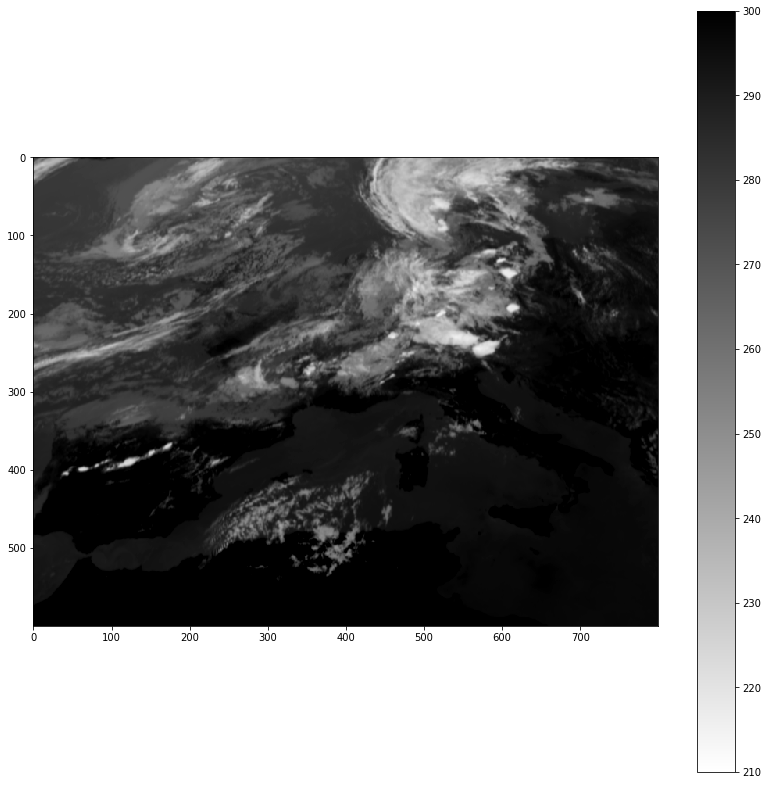

In [7]:
fig, ax = plt.subplots(1,1,figsize=(14,14))
plot = ax.imshow(bt_smooth, vmin=210,vmax=300,cmap='gray_r')
fig.colorbar(plot)

Danach quantisieren wir das geglättete Feld.

In [8]:
bt_quant = quantise_field(bt_smooth,210,290,-10)

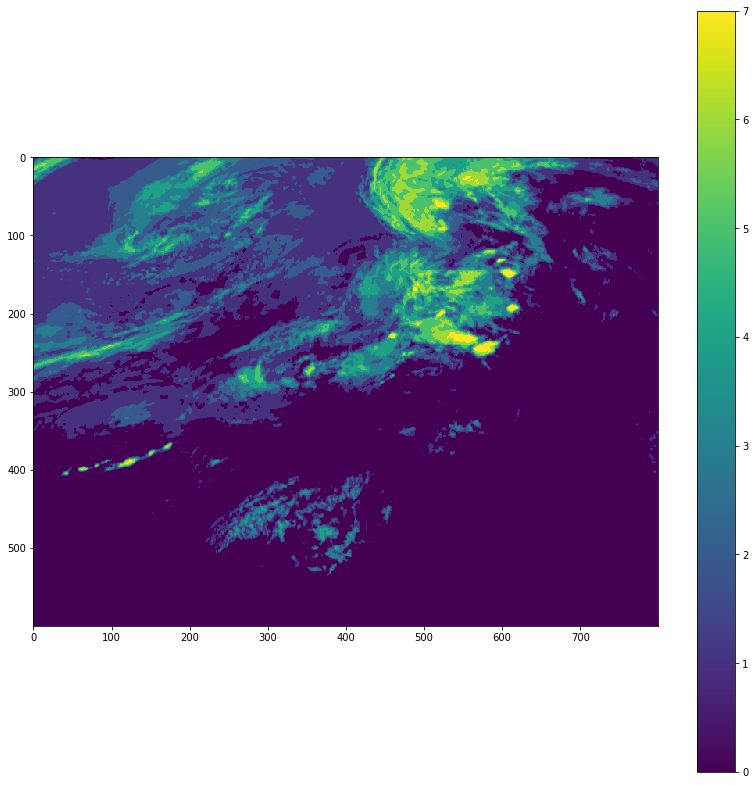

In [9]:
fig, ax = plt.subplots(1,1,figsize=(14,14))
plot = ax.imshow(bt_quant)
fig.colorbar(plot)

Im nächsten Schritt suchen wir uns die Maxima.

In [10]:
lmax = skmor.extrema.local_maxima(bt_quant)
lmax_labeled, nmax = ndi.label(lmax)

Danach speichern wir die Pixel im Bild mit einem Wert größer als Null in eine Datenstruktur.

In [15]:
pixel_structure = create_structure(bt_quant,np.max(bt_quant).astype("int"))

In [16]:
pixel_structure

{0: [(0, 60),
  (0, 61),
  (0, 62),
  (0, 63),
  (0, 64),
  (0, 65),
  (0, 66),
  (0, 67),
  (0, 68),
  (0, 69),
  (0, 70),
  (0, 71),
  (0, 72),
  (0, 73),
  (0, 74),
  (0, 75),
  (0, 76),
  (0, 77),
  (0, 78),
  (0, 79),
  (0, 80),
  (0, 81),
  (0, 82),
  (0, 83),
  (0, 84),
  (0, 85),
  (0, 86),
  (0, 87),
  (0, 88),
  (0, 94),
  (0, 95),
  (0, 96),
  (0, 97),
  (0, 98),
  (0, 99),
  (0, 100),
  (0, 101),
  (0, 102),
  (0, 103),
  (0, 104),
  (0, 706),
  (0, 707),
  (0, 708),
  (0, 713),
  (0, 714),
  (0, 715),
  (0, 716),
  (0, 717),
  (0, 718),
  (0, 719),
  (0, 720),
  (0, 721),
  (0, 722),
  (0, 723),
  (0, 724),
  (0, 725),
  (0, 726),
  (0, 727),
  (0, 728),
  (0, 729),
  (0, 730),
  (0, 731),
  (0, 732),
  (0, 733),
  (0, 734),
  (0, 735),
  (0, 736),
  (0, 737),
  (0, 738),
  (0, 739),
  (0, 740),
  (0, 741),
  (0, 742),
  (0, 743),
  (0, 744),
  (0, 745),
  (0, 746),
  (0, 747),
  (0, 748),
  (0, 749),
  (0, 750),
  (0, 751),
  (0, 752),
  (0, 753),
  (0, 754),
  (0, 755),


Als nächstes wir uns die Schwerpunkte der Maximaobjekte und speichern sie ebenfalls in eine Struktur.

In [17]:
# find centers of the maxima
centers = {l:[] for l in np.arange(1,np.max(bt_quant).astype("int")+1)}

for label in xrange(1,nmax):

    cx,cy = ndi.measurements.center_of_mass(lmax,labels=lmax_labeled,index=label)

    level = bt_quant[int(np.rint(cx)),int(np.rint(cy))].astype("int")

    centers[level].append((cx,cy))

NameError: name 'xrange' is not defined

Nun können wir die Objekte finden. Dafür müssen wir noch eine Mindestgröße ("Salienz") und eine Maximaltiefe definieren.

In [137]:
basins = np.full_like(bt_smooth,-1)

saliency = 4
max_depth = 2

In [150]:
filled_basins = find_basins(pixel_structure,centers,np.max(bt_quant).astype("int"),max_depth,basins,bt_quant,saliency) 

Bestimme Laenge. Laenge ist: 1
Koordinaten sind c=4, r=789
Koordinaten ans Becken angehaengt.
[[  4. 789.]]
Suche Nachbarn.
Die Nachbarn sind:
[[ -1  -1]
 [  3 788]
 [  3 789]
 [  3 790]
 [  4 788]
 [  4 790]
 [  5 788]
 [  5 789]
 [  5 790]]
Ueberpruefe, ob Punkt ueber Schwellwert liegt.
Haenge Nachbarn an Bergfuss an.
Bestimme wieder die Laenge.
Laenge = 1
Durchlaufe das Becken mit der Groesse 1, Schwellwert ist 4
Becken ist zu klein. Groesse 1,2
[  4. 789.]
Weisse Punkt 4,789 dem Bergfuss zu.
Durchlaufe Bergfuesse.
Gebe Becken zurueck.
Bestimme Laenge. Laenge ist: 1
Koordinaten sind c=94, r=714
Koordinaten ans Becken angehaengt.
[[ 94. 714.]]
Suche Nachbarn.
Die Nachbarn sind:
[[ -1  -1]
 [ 93 713]
 [ 93 714]
 [ 93 715]
 [ 94 713]
 [ 94 715]
 [ 95 713]
 [ 95 714]
 [ 95 715]]
Ueberpruefe, ob Punkt ueber Schwellwert liegt.
Haenge Nachbarn an Bergfuss an.
Bestimme wieder die Laenge.
Laenge = 1
Durchlaufe das Becken mit der Groesse 1, Schwellwert ist 4
Becken ist zu klein. Groesse 1,2
[

Bestimme wieder die Laenge.
Laenge = 1
Durchlaufe das Becken mit der Groesse 1, Schwellwert ist 4
Becken ist zu klein. Groesse 1,2
[177. 700.]
Weisse Punkt 177,700 dem Bergfuss zu.
Durchlaufe Bergfuesse.
Gebe Becken zurueck.
Bestimme Laenge. Laenge ist: 1
Koordinaten sind c=180, r=379
Koordinaten ans Becken angehaengt.
[[180. 379.]]
Suche Nachbarn.
Die Nachbarn sind:
[[ -1  -1]
 [179 378]
 [179 379]
 [179 380]
 [180 378]
 [180 380]
 [181 378]
 [181 379]
 [181 380]]
Ueberpruefe, ob Punkt ueber Schwellwert liegt.
Haenge Nachbarn an Bergfuss an.
Bestimme wieder die Laenge.
Laenge = 1
Durchlaufe das Becken mit der Groesse 1, Schwellwert ist 4
Becken ist zu klein. Groesse 1,2
[180. 379.]
Weisse Punkt 180,379 dem Bergfuss zu.
Durchlaufe Bergfuesse.
Gebe Becken zurueck.
Bestimme Laenge. Laenge ist: 1
Koordinaten sind c=202, r=136
Koordinaten ans Becken angehaengt.
[[202. 136.]]
Suche Nachbarn.
Die Nachbarn sind:
[[ -1  -1]
 [201 135]
 [201 136]
 [201 137]
 [202 135]
 [202 137]
 [203 135]
 [20

Bestimme Laenge. Laenge ist: 1
Koordinaten sind c=92, r=290
Koordinaten ans Becken angehaengt.
[[ 92. 290.]]
Suche Nachbarn.
Die Nachbarn sind:
[[ -1  -1]
 [ 91 289]
 [ 91 290]
 [ 91 291]
 [ 92 289]
 [ 92 291]
 [ 93 289]
 [ 93 290]
 [ 93 291]]
Ueberpruefe, ob Punkt ueber Schwellwert liegt.
Haenge Nachbarn an Bergfuss an.
Bestimme wieder die Laenge.
Laenge = 1
Durchlaufe das Becken mit der Groesse 1, Schwellwert ist 4
Becken ist zu klein. Groesse 1,2
[ 92. 290.]
Weisse Punkt 92,290 dem Bergfuss zu.
Durchlaufe Bergfuesse.
Gebe Becken zurueck.
Bestimme Laenge. Laenge ist: 1
Koordinaten sind c=93, r=217
Koordinaten ans Becken angehaengt.
[[ 93. 217.]]
Suche Nachbarn.
Die Nachbarn sind:
[[ -1  -1]
 [ 92 216]
 [ 92 217]
 [ 92 218]
 [ 93 216]
 [ 93 218]
 [ 94 216]
 [ 94 217]
 [ 94 218]]
Ueberpruefe, ob Punkt ueber Schwellwert liegt.
Haenge Nachbarn an Bergfuss an.
Bestimme wieder die Laenge.
Laenge = 1
Durchlaufe das Becken mit der Groesse 1, Schwellwert ist 4
Becken ist zu klein. Groesse 1,2

[[ 57. 219.]]
Suche Nachbarn.
Die Nachbarn sind:
[[ -1  -1]
 [ 56 218]
 [ 56 219]
 [ 56 220]
 [ 57 218]
 [ 57 220]
 [ 58 218]
 [ 58 219]
 [ 58 220]]
Ueberpruefe, ob Punkt ueber Schwellwert liegt.
Haenge Nachbarn an Bergfuss an.
Bestimme wieder die Laenge.
Laenge = 1
Durchlaufe das Becken mit der Groesse 1, Schwellwert ist 4
Becken ist zu klein. Groesse 1,2
[ 57. 219.]
Weisse Punkt 57,219 dem Bergfuss zu.
Durchlaufe Bergfuesse.
Gebe Becken zurueck.
Bestimme Laenge. Laenge ist: 1
Koordinaten sind c=65, r=165
Koordinaten ans Becken angehaengt.
[[ 65. 165.]]
Suche Nachbarn.
Die Nachbarn sind:
[[ -1  -1]
 [ 64 164]
 [ 64 165]
 [ 64 166]
 [ 65 164]
 [ 65 166]
 [ 66 164]
 [ 66 165]
 [ 66 166]]
Ueberpruefe, ob Punkt ueber Schwellwert liegt.
Haenge Nachbarn an Bergfuss an.
Bestimme wieder die Laenge.
Laenge = 1
Durchlaufe das Becken mit der Groesse 1, Schwellwert ist 4
Becken ist zu klein. Groesse 1,2
[ 65. 165.]
Weisse Punkt 65,165 dem Bergfuss zu.
Durchlaufe Bergfuesse.
Gebe Becken zurueck.
B

Bestimme Laenge. Laenge ist: 1
Koordinaten sind c=58, r=483
Koordinaten ans Becken angehaengt.
[[ 58. 483.]]
Suche Nachbarn.
Die Nachbarn sind:
[[ -1  -1]
 [ 57 482]
 [ 57 483]
 [ 57 484]
 [ 58 482]
 [ 58 484]
 [ 59 482]
 [ 59 483]
 [ 59 484]]
Ueberpruefe, ob Punkt ueber Schwellwert liegt.
Haenge Nachbarn an Bergfuss an.
Bestimme wieder die Laenge.
Laenge = 1
Durchlaufe das Becken mit der Groesse 1, Schwellwert ist 4
Becken ist zu klein. Groesse 1,2
[ 58. 483.]
Weisse Punkt 58,483 dem Bergfuss zu.
Durchlaufe Bergfuesse.
Gebe Becken zurueck.
Bestimme Laenge. Laenge ist: 1
Koordinaten sind c=27, r=565
Koordinaten ans Becken angehaengt.
[[ 27. 565.]]
Suche Nachbarn.
Die Nachbarn sind:
[[ -1  -1]
 [ 26 564]
 [ 26 565]
 [ 26 566]
 [ 27 564]
 [ 27 566]
 [ 28 564]
 [ 28 565]
 [ 28 566]]
Ueberpruefe, ob Punkt ueber Schwellwert liegt.
Haenge Nachbarn an Bergfuss an.
Bestimme wieder die Laenge.
Laenge = 1
Durchlaufe das Becken mit der Groesse 1, Schwellwert ist 4
Becken ist zu klein. Groesse 1,2

IndexError: Out of bounds on buffer access (axis 1)

In [151]:
plt.imshow(filled_basins)

NameError: name 'filled_basins' is not defined